In [1]:
#Import necessary packages

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split 
import re
from bs4 import BeautifulSoup

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/NLP/')

In [4]:
#Read input excel sheet

df = pd.read_excel("input_data.xlsx", sheet_name=None)

In [5]:
#Get the dataframe from first sheet

dfn = df['Sheet1']

In [6]:
#Lets see head of the dataframe

dfn.head()

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


In [ ]:
#Shape of the dataframe

dfn.shape

(8500, 4)

In [ ]:
#Check data types

dfn.dtypes

Short description    object
Description          object
Caller               object
Assignment group     object
dtype: object

In [ ]:
#Check for blanks

dfn.isna().sum()

Short description    8
Description          1
Caller               0
Assignment group     0
dtype: int64

In [ ]:
#We are more interested in Description column as it clearly looks like superset of short description
#So lets see that row with blank value for Description

dfn[dfn['Description'].isna()]

,Short description,Description,Caller,Assignment group
4395,i am locked out of skype,NaN,viyglzfo ajtfzpkb,GRP_0


In [7]:
#Lets fill the description value above with what we have for short description

dfn.iloc[4395, dfn.columns.get_loc('Description')] = dfn.iloc[4395, dfn.columns.get_loc('Short description')]

In [ ]:
#Lets check for nulls

dfn.isnull().sum()

Short description    8
Description          0
Caller               0
Assignment group     0
dtype: int64

We will be using Description column data for training, so we can ignore Short description and Caller

In [8]:
dfn = dfn.drop(['Short description'], axis=1)
dfn = dfn.drop(['Caller'], axis=1)

In [9]:
#We noticed there are so many unwanted sequences in Description column
#Lets get rid of those

dfn["Description"] = dfn["Description"].astype(str) 
dfn = dfn.replace('\r\n','', regex=True)

In [10]:
#Remove Date and time from description

dfn["Description"] = dfn["Description"].replace('\d{2}/\d{2}/\d{4} \d{2}:\d{2}:\d{2}','', regex=True)

In [11]:
#Remove html characters if any

def strip_html_tags(text):
    """remove html tags from text"""
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text(separator=" ")
    return stripped_text

dfn['Description'] = dfn['Description'].apply(lambda x: strip_html_tags(x))

In [ ]:
pip install unidecode

     |████████████████████████████████| 245kB 6.9MB/s 


In [12]:
#Remove Accented Characters if any
import unidecode

def remove_accented_chars(text):
    """remove accented characters from text, e.g. café"""
    text = unidecode.unidecode(text)
    return text

dfn['Description'] = dfn['Description'].apply(lambda x: remove_accented_chars(x))

In [ ]:
pip install -U nltk

     |████████████████████████████████| 1.4MB 7.0MB/s 
  Created wheel for nltk: filename=nltk-3.5-cp36-none-any.whl size=1434680 sha256=a56dcade28a9111618c6e5e72db10dfca2c8d3257d6f7c50102d1b330d5edd7e
  Stored in directory: /root/.cache/pip/wheels/ae/8c/3f/b1fe0ba04555b08b57ab52ab7f86023639a526d8bc8d384306
Successfully built nltk
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [13]:
#Filter out punctuations

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize


def filter_punctuations(text):
    tokens = word_tokenize(text)
    # remove all tokens that are not alphabetic
    words = [word for word in tokens if word.isalpha()]
    return ' '.join(words)

dfn['Description'] = dfn['Description'].apply(lambda x: filter_punctuations(x))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
#Lowercase the description

dfn['Description'] = dfn['Description'].apply(lambda x: x.lower())

In [15]:
#Remove digits and word containing digits

dfn['Description'] = dfn['Description'].apply(lambda x: re.sub('\w*\d\w*','', x))

In [16]:
#Expand Contractions

# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

dfn['Description'] = dfn['Description'].apply(lambda x:expand_contractions(x))

In [17]:
#Filter out stopwords

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

def filter_stopwords(text):
    tokens = word_tokenize(text)
    # remove all tokens that are stopwords
    stop_words = set(stopwords.words('english'))
    words = [w for w in tokens if not w in stop_words]
    return ' '.join(words)

dfn['Description'] = dfn['Description'].apply(lambda x: filter_stopwords(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
#Lemmatization

import spacy

# Loading model
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

dfn['lemmatized'] = dfn['Description'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x))]))


In [19]:
#Check and remove empty rows after lemmatization

print(dfn.shape)
dfn = dfn[dfn['lemmatized'] != '']
print(dfn.shape)

(8500, 3)
(8430, 3)


In [20]:
#Lets group the lemmatized descriptions based on assignment groups

df_grouped = dfn[['Assignment group','lemmatized']].groupby(by='Assignment group').agg(lambda x:' '.join(x))
df_grouped.head(20)

,lemmatized
Assignment group,
GRP_0,user details employee manager name user name a...
GRP_1,event critical value mountpoint threshold toda...
GRP_10,receive fail receive fail receive fail receive...
GRP_11,hello service nee monitor manufacture drawing ...
GRP_12,c label server space consume space available g...
GRP_13,receive fail receive two customer account get ...
GRP_14,intermittent service configair server require ...
GRP_15,hi channel partner email address djhadkudhd re...
GRP_16,receive cid bwfhtumx japznrvb regional control...


In [21]:
# Lets create Document Term Matrix

from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(analyzer='word')
data = cv.fit_transform(df_grouped['lemmatized'])

df_dtm = pd.DataFrame(data.toarray(), columns=cv.get_feature_names())
df_dtm.index = df_grouped.index
df_dtm.head(10)

,aa,aaa,aaeur,aao,aaymanncustom,ab,abandon,abap,abarbeiten,abc,abca,abcdegy,abcdri,abd,abdhtyu,abend,abende,abended,aber,abertura,abfragetimeout,abgebildet,abgebrochen,abgelaufen,abgeschlossen,abgesprochen,abgrtyreu,abhanden,abhandengekommen,abhay,abhilfe,abholen,abholung,ability,abl,able,abmelden,abode,abort,abovementione,...,zugang,zugordnet,zugriff,zugriffe,zugriffs,zugriffsrechte,zuhause,zuhoylts,zukommen,zulassen,zum,zumindest,zuothryrt,zur,zura,zurtxjbd,zurzeit,zusammen,zuschaltung,zusta,zuteillisten,zuvjqgwa,zuvor,zuyimtsf,zvjxuahe,zvmesjpt,zvnxlobq,zvnxlobqdirecteur,zvygmnco,zwar,zwei,zweites,zwip,zwischen,zwrypjqv,zwutmehy,zwwirep,zxdtskpw,zyjfpgtk,zz
Assignment group,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
GRP_0,0,2,0,0,1,1,0,2,0,1,0,0,1,1,2,0,0,0,7,0,0,0,1,0,1,0,1,1,0,0,2,0,0,1,1,266,0,0,0,0,...,1,0,18,1,1,0,1,1,0,0,3,0,1,1,8,0,1,4,1,0,1,0,0,0,0,0,1,0,1,1,1,0,0,1,0,0,0,1,0,0
GRP_1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GRP_10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GRP_11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
GRP_12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,9,0,0,0,0,...,0,0,7,0,0,1,0,0,0,1,1,0,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GRP_13,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GRP_14,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GRP_15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GRP_16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Importing wordcloud for plotting word clouds and textwrap for wrapping longer text
from wordcloud import WordCloud
from textwrap import wrap

# Function for generating word clouds
def generate_wordcloud(data,title):
  try:
    wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate_from_frequencies(data)
    plt.figure(figsize=(10,8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title('\n'.join(wrap(title,60)),fontsize=13)
    plt.show()
  except:
    print("Error happened")
  
# Transposing document term matrix
df_dtm = df_dtm.transpose()


# Plotting word cloud for each group
for index, group in enumerate(df_dtm.columns):
    generate_wordcloud(df_dtm[group].sort_values(ascending=False), group)

Output hidden; open in https://colab.research.google.com to view.

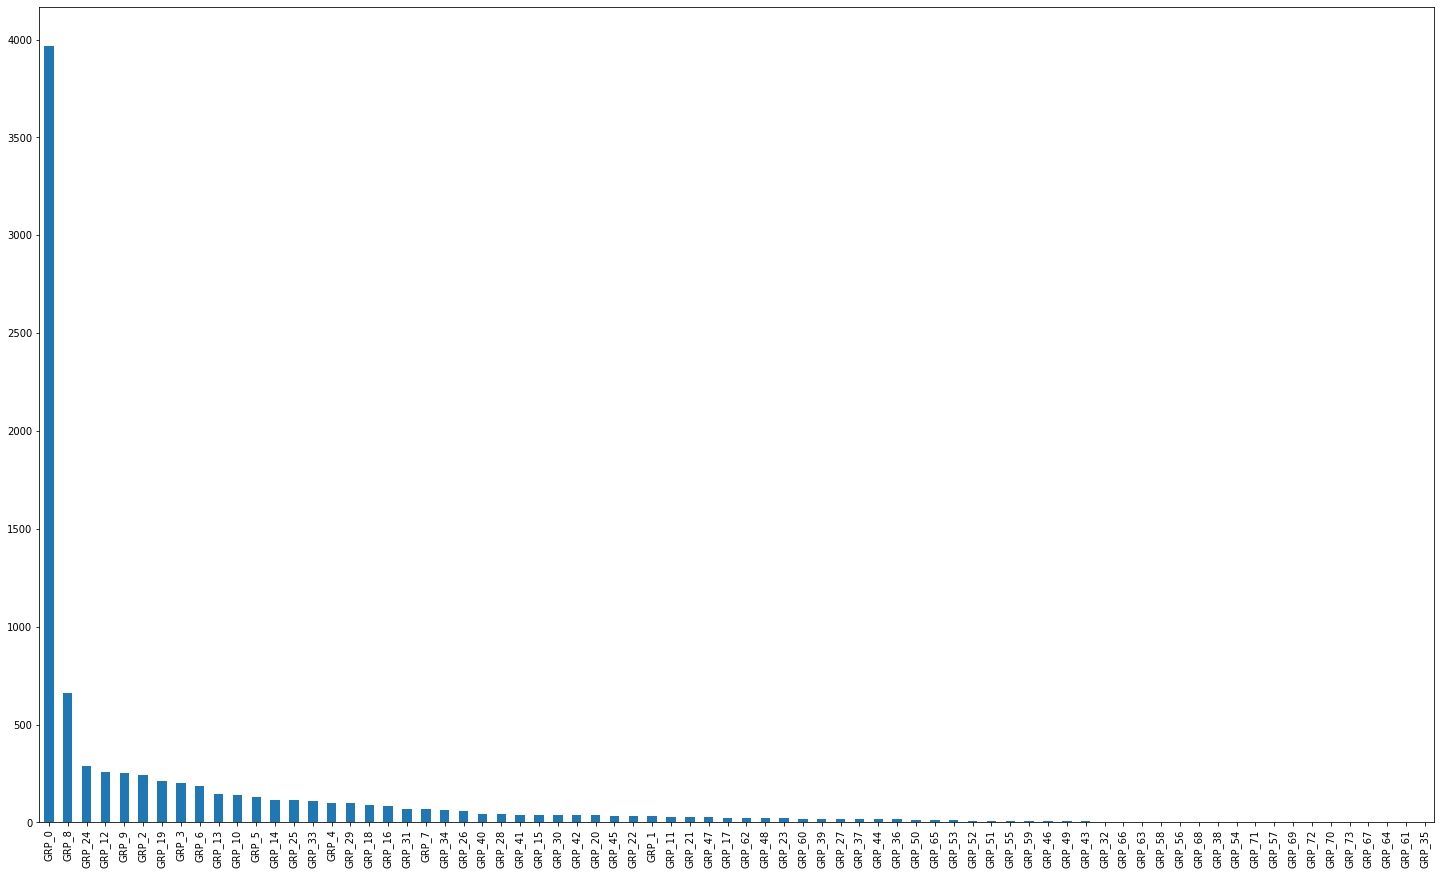

In [ ]:
#Lets check how balanced our classification is

dfn['Assignment group'].value_counts().plot(kind='bar', figsize=(25,15));

We can see how unbalanced our dataset is. We will try to make use of NLP data augmentation techniques.

In [22]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

# Easy data augmentation techniques for text classification

import random
from random import shuffle
random.seed(1)

# stop words list

stop_words = [
    'i',
    'me',
    'my',
    'myself',
    'we',
    'our',
    'ours',
    'ourselves',
    'you',
    'your',
    'yours',
    'yourself',
    'yourselves',
    'he',
    'him',
    'his',
    'himself',
    'she',
    'her',
    'hers',
    'herself',
    'it',
    'its',
    'itself',
    'they',
    'them',
    'their',
    'theirs',
    'themselves',
    'what',
    'which',
    'who',
    'whom',
    'this',
    'that',
    'these',
    'those',
    'am',
    'is',
    'are',
    'was',
    'were',
    'be',
    'been',
    'being',
    'have',
    'has',
    'had',
    'having',
    'do',
    'does',
    'did',
    'doing',
    'a',
    'an',
    'the',
    'and',
    'but',
    'if',
    'or',
    'because',
    'as',
    'until',
    'while',
    'of',
    'at',
    'by',
    'for',
    'with',
    'about',
    'against',
    'between',
    'into',
    'through',
    'during',
    'before',
    'after',
    'above',
    'below',
    'to',
    'from',
    'up',
    'down',
    'in',
    'out',
    'on',
    'off',
    'over',
    'under',
    'again',
    'further',
    'then',
    'once',
    'here',
    'there',
    'when',
    'where',
    'why',
    'how',
    'all',
    'any',
    'both',
    'each',
    'few',
    'more',
    'most',
    'other',
    'some',
    'such',
    'no',
    'nor',
    'not',
    'only',
    'own',
    'same',
    'so',
    'than',
    'too',
    'very',
    's',
    't',
    'can',
    'will',
    'just',
    'don',
    'should',
    'now',
    '',
    ]

# cleaning up text

import re


def get_only_chars(line):

    clean_line = ''

    line = line.replace('\xe2\x80\x99', '')
    line = line.replace("'", '')
    line = line.replace('-', ' ')  # replace hyphens with spaces
    line = line.replace('\t', ' ')
    line = line.replace('\n', ' ')
    line = line.lower()

    for char in line:
        if char in 'qwertyuiopasdfghjklzxcvbnm ':
            clean_line += char
        else:
            clean_line += ' '

    clean_line = re.sub(' +', ' ', clean_line)  # delete extra spaces
    if len(clean_line) > 0 and clean_line[0] == ' ':
        clean_line = clean_line[1:]
    return clean_line


########################################################################
# Synonym replacement
# Replace n words in the sentence with synonyms from wordnet
########################################################################

import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet


def synonym_replacement(words, n):
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word
                            not in stop_words]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [(synonym if word == random_word else word)
                         for word in new_words]

            # print("replaced", random_word, "with", synonym)

            num_replaced += 1
        if num_replaced >= n:  # only replace up to n words
            break

    # this is stupid but we need it, trust me

    sentence = ' '.join(new_words)
    new_words = sentence.split(' ')

    return new_words


def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            synonym = l.name().replace('_', ' ').replace('-', ' '
                    ).lower()
            synonym = ''.join([char for char in synonym if char
                              in ' qwertyuiopasdfghjklzxcvbnm'])
            synonyms.add(synonym)
    if word in synonyms:
        synonyms.remove(word)
    return list(synonyms)


########################################################################
# Random deletion
# Randomly delete words from the sentence with probability p
########################################################################

def random_deletion(words, p):

    # obviously, if there's only one word, don't delete it

    if len(words) == 1:
        return words

    # randomly delete words with probability p

    new_words = []
    for word in words:
        r = random.uniform(0, 1)
        if r > p:
            new_words.append(word)

    # if you end up deleting all words, just return a random word

    if len(new_words) == 0:
        rand_int = random.randint(0, len(words) - 1)
        return [words[rand_int]]

    return new_words


########################################################################
# Random swap
# Randomly swap two words in the sentence n times
########################################################################

def random_swap(words, n):
    new_words = words.copy()
    for _ in range(n):
        new_words = swap_word(new_words)
    return new_words


def swap_word(new_words):
    random_idx_1 = random.randint(0, len(new_words) - 1)
    random_idx_2 = random_idx_1
    counter = 0
    while random_idx_2 == random_idx_1:
        random_idx_2 = random.randint(0, len(new_words) - 1)
        counter += 1
        if counter > 3:
            return new_words
    (new_words[random_idx_1], new_words[random_idx_2]) = \
        (new_words[random_idx_2], new_words[random_idx_1])
    return new_words


########################################################################
# Random insertion
# Randomly insert n words into the sentence
########################################################################

def random_insertion(words, n):
    new_words = words.copy()
    for _ in range(n):
        add_word(new_words)
    return new_words


def add_word(new_words):
    synonyms = []
    counter = 0
    while len(synonyms) < 1:
        random_word = new_words[random.randint(0, len(new_words) - 1)]
        synonyms = get_synonyms(random_word)
        counter += 1
        if counter >= 10:
            return
    random_synonym = synonyms[0]
    random_idx = random.randint(0, len(new_words) - 1)
    new_words.insert(random_idx, random_synonym)


########################################################################
# main data augmentation function
########################################################################

def eda(
    sentence,
    alpha_sr=0.1,
    alpha_ri=0.1,
    alpha_rs=0.1,
    p_rd=0.1,
    num_aug=9,
    ri=True,
    rd=True,
    ):

    sentence = get_only_chars(sentence)
    words = sentence.split(' ')
    words = [word for word in words if word is not '']
    num_words = len(words)

    augmented_sentences = []
    num_new_per_technique = int(num_aug / 4) + 1
    n_sr = max(1, int(alpha_sr * num_words))
    n_ri = max(1, int(alpha_ri * num_words))
    n_rs = max(1, int(alpha_rs * num_words))

    # sr
    for _ in range(num_new_per_technique):
        a_words = synonym_replacement(words, n_sr)
        augmented_sentences.append(' '.join(a_words))

    # ri
    if ri:
        for _ in range(num_new_per_technique):
            a_words = random_insertion(words, n_ri)
            augmented_sentences.append(' '.join(a_words))

    # rs
    for _ in range(num_new_per_technique):
        a_words = random_swap(words, n_rs)
        augmented_sentences.append(' '.join(a_words))

    # rd
    if rd:
        for _ in range(num_new_per_technique):
            a_words = random_deletion(words, p_rd)
            augmented_sentences.append(' '.join(a_words))

    augmented_sentences = [get_only_chars(sentence) for sentence in
                           augmented_sentences]
    shuffle(augmented_sentences)

    # trim so that we have the desired number of augmented sentences
    if num_aug >= 1:
        augmented_sentences = augmented_sentences[:num_aug]
    else:
        keep_prob = num_aug / len(augmented_sentences)
        augmented_sentences = [s for s in augmented_sentences
                               if random.uniform(0, 1) < keep_prob]

    # append the original sentence
    augmented_sentences.append(sentence)

    return augmented_sentences

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [23]:
#We dont need Description column anymore

dfn = dfn.drop(['Description'], axis=1)

In [24]:
#Lets augment text for groups other than GRP_0

df_aug = pd.DataFrame(columns=dfn.columns)

for index, row in dfn.iterrows():
  if row['Assignment group'] != 'GRP_0':
      sentences = eda(row['lemmatized'])
      for sentence in sentences:
        df_aug = df_aug.append({'Assignment group': row['Assignment group'], 'lemmatized': sentence}, ignore_index=True)
df_aug.head()

,Assignment group,lemmatized
0,GRP_1,mountpoint critical value event threshold
1,GRP_1,consequence critical value mountpoint threshold
2,GRP_1,event critical value mountpoint threshold
3,GRP_1,limen event critical value mountpoint threshold
4,GRP_1,event critical value mountpoint threshold


In [25]:
#Append df_aug to parent dataframe dfn

dfn = dfn.append(df_aug) 

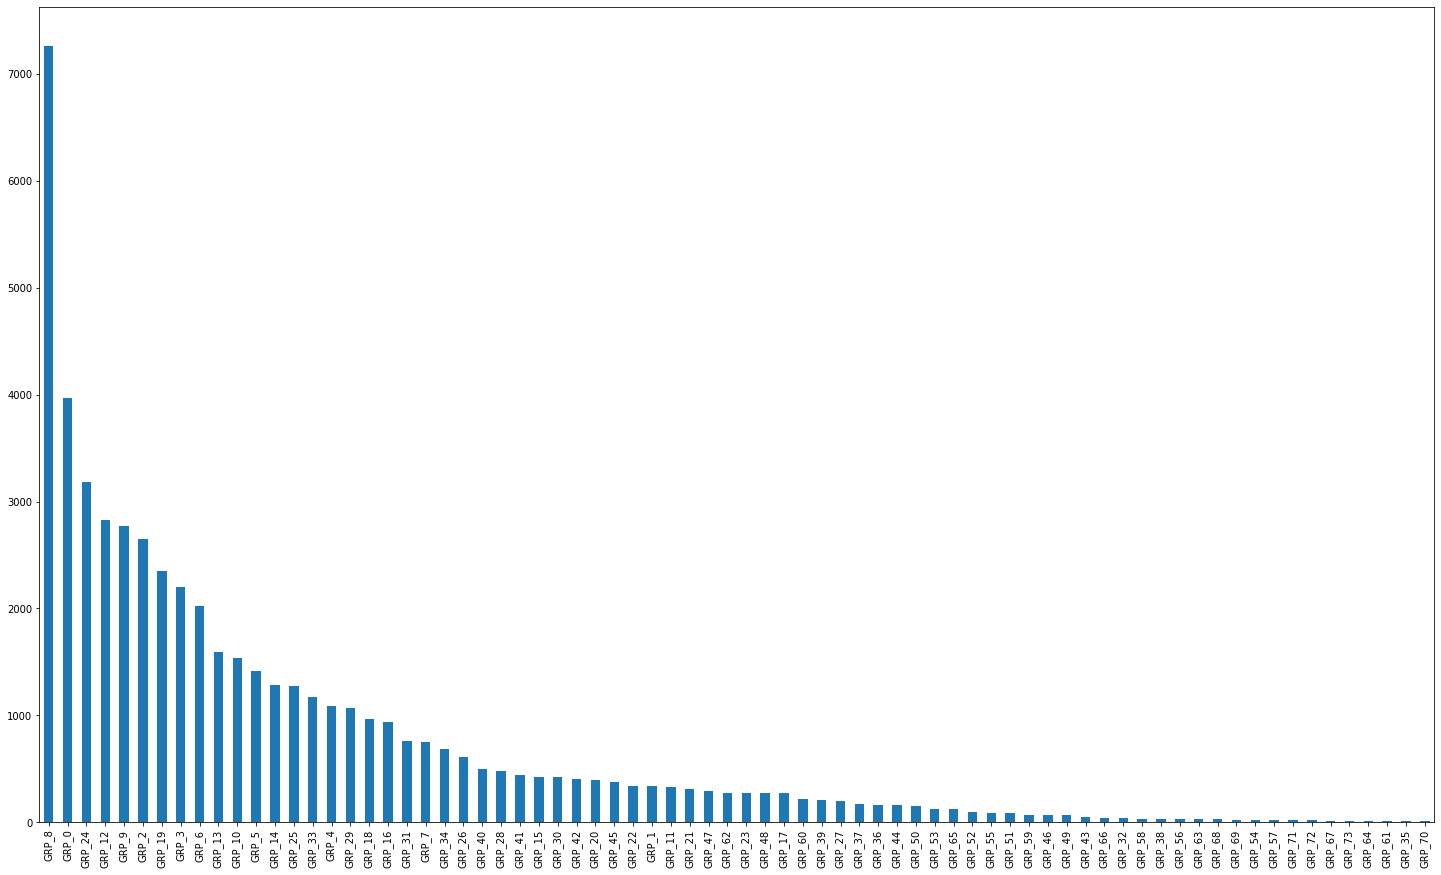

In [26]:
#Lets check classification plot again

dfn['Assignment group'].value_counts().plot(kind='bar', figsize=(25,15));

In [27]:
#Separate train and target columns

X = dfn.lemmatized
y = dfn['Assignment group']

In [28]:
#Split the data into train and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Lets try our "Naive" Naive Bayes Classification

In [29]:
groupNames = dfn['Assignment group'].unique()

In [30]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))

accuracy 0.6319509896324222


# Lets try text classification using Keras 

In [31]:
dfn['AG'] = dfn['Assignment group'].str[4:]
lbls = dfn["AG"].values
labels = [int(numeric_string) for numeric_string in lbls]

In [32]:
import numpy as np

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

train_size = int(len(dfn) * .7)
train_posts = dfn['lemmatized'][:train_size]
train_tags = dfn['AG'][:train_size]

test_posts = dfn['lemmatized'][train_size:]
test_tags = dfn['AG'][train_size:]

max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_posts) # only fit on train

x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

batch_size = 32
epochs = 50

# Build the model
kmodel = Sequential()
kmodel.add(Dense(512, input_shape=(max_words,)))
kmodel.add(Activation('relu'))
kmodel.add(Dropout(0.5))
kmodel.add(Dense(num_classes))
kmodel.add(Activation('softmax'))

kmodel.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              
history = kmodel.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/50
1045/1045 [==============================] - 4s 4ms/step - loss: 1.7021 - accuracy: 0.5699 - val_loss: 1.8887 - val_accuracy: 0.4467
Epoch 2/50
1045/1045 [==============================] - 4s 4ms/step - loss: 0.8385 - accuracy: 0.7594 - val_loss: 1.6700 - val_accuracy: 0.4949
Epoch 3/50
1045/1045 [==============================] - 4s 4ms/step - loss: 0.6808 - accuracy: 0.7985 - val_loss: 1.4690 - val_accuracy: 0.5318
Epoch 4/50
1045/1045 [==============================] - 4s 4ms/step - loss: 0.6066 - accuracy: 0.8155 - val_loss: 1.3336 - val_accuracy: 0.5654
Epoch 5/50
1045/1045 [==============================] - 4s 4ms/step - loss: 0.5577 - accuracy: 0.8272 - val_loss: 1.1874 - val_accuracy: 0.6101
Epoch 6/50
1045/1045 [==============================] - 4s 4ms/step - loss: 0.5250 - accuracy: 0.8344 - val_loss: 1.0872 - val_accuracy: 0.6500
Epoch 7/50
1045/1045 [==============================] - 4s 4ms/step - loss: 0.4978 - accuracy: 0.8414 - val_loss: 0.9431 - val_accuracy:

# We should try Transformers! Lets try Bert

In [33]:
pip install transformers

In [34]:
import transformers
import numpy as np

txt = "bank river"
## bert tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
## bert model
nlp = transformers.TFBertModel.from_pretrained('bert-base-uncased')
## return hidden layer with embeddings
input_ids = np.array(tokenizer.encode(txt))[None,:]  
embedding = nlp(input_ids)
embedding[0][0]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertModel for predictions without further training.


<tf.Tensor: shape=(4, 768), dtype=float32, numpy=
array([[-0.34245902,  0.05200406, -0.25653803, ..., -0.24441747,
         0.05279738,  0.44900548],
       [-0.38362464, -0.6671507 , -0.3502136 , ..., -0.10210574,
        -0.21629463, -0.29299977],
       [-0.34996033, -0.08316943, -0.98768383, ...,  0.06963158,
        -0.49453112, -0.16088413],
       [ 0.7392341 ,  0.07392042, -0.45680982, ..., -0.02415731,
        -0.76496524, -0.28110695]], dtype=float32)>

In [35]:
def getSegs(corpus):
  maxlen = 50

  ## add special tokens
  maxqnans = np.int((maxlen-20)/2)
  corpus_tokenized = ["[CLS] "+
              " ".join(tokenizer.tokenize(re.sub(r'[^\w\s]+|\n', '', 
              str(txt).lower().strip()))[:maxqnans])+
              " [SEP] " for txt in corpus]

  ## generate masks
  masks = [[1]*len(txt.split(" ")) + [0]*(maxlen - len(
            txt.split(" "))) for txt in corpus_tokenized]
      
  ## padding
  txt2seq = [txt + " [PAD]"*(maxlen-len(txt.split(" "))) if len(txt.split(" ")) != maxlen else txt for txt in corpus_tokenized]
      
  ## generate idx
  idx = [tokenizer.encode(seq.split(" "), max_length=maxlen, truncation=True) for seq in txt2seq]


  ## generate segments
  segments = [] 
  for seq in txt2seq:
      temp, i = [], 0
      for token in seq.split(" "):
          temp.append(i)
          if token == "[SEP]":
              i += 1
      segments.append(temp)
  
  return idx, masks, segments

In [36]:
#Separate train and target columns

X = dfn.drop(['Assignment group', 'AG'], axis=1)
y = dfn['Assignment group']

In [37]:
#Split the data into train and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [38]:
#Lets create feature matrix for training set

corpus = X_train["lemmatized"]

idx, masks, segments = getSegs(corpus)

## feature matrix
X_train_m = [np.asarray(idx, dtype='int32'), 
           np.asarray(masks, dtype='int32'), 
           np.asarray(segments, dtype='int32')]


In [68]:
dfn.head()

,Short description,Description,Caller,Assignment group,AG
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0,0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0,0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,0


In [39]:
#Do the same for test data

corpus = X_test["lemmatized"]

idx, masks, segments = getSegs(corpus)
  
## feature matrix
X_test_m = [np.asarray(idx, dtype='int32'), 
           np.asarray(masks, dtype='int32'), 
           np.asarray(segments, dtype='int32')]


In [41]:
#Build the model

from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling1D
from tensorflow.keras.models import Model

## inputs
idx = Input((50), dtype="int32", name="input_idx")
masks = Input((50), dtype="int32", name="input_masks")
segments = Input((50), dtype="int32", name="input_segments")

## pre-trained bert
nlp = transformers.TFBertModel.from_pretrained("bert-base-uncased")
bert_out, _ = nlp([idx, masks, segments])

## fine-tuning
x = GlobalAveragePooling1D()(bert_out)
x = Dense(64, activation="relu")(x)
y_out = Dense(len(np.unique(y_train)), activation='softmax')(x)

## compile
bmodel = Model([idx, masks, segments], y_out)

for layer in bmodel.layers[:4]:
    layer.trainable = False

bmodel.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
bmodel.summary()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_idx (InputLayer)          [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_segments (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
tf_bert_model_2 (TFBertModel)   ((None, 50, 768), (N 109482240   input_idx[0][0]                  
                                                                 input_masks[0][0]     

In [43]:
#Lets train, test and evaluate

## encode y
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])


## train
training = bmodel.fit(x=X_train_m, y=y_train, batch_size=64, 
                     epochs=50, shuffle=True, verbose=1, 
                     validation_split=0.3)

## test
predicted_prob = bmodel.predict(X_test_m)
predicted = [dic_y_mapping[np.argmax(pred)] for pred in 
             predicted_prob]

Epoch 1/50
465/465 [==============================] - 255s 549ms/step - loss: 2.6818 - accuracy: 0.3115 - val_loss: 2.3371 - val_accuracy: 0.3612
Epoch 2/50
465/465 [==============================] - 252s 542ms/step - loss: 2.2580 - accuracy: 0.3829 - val_loss: 2.1374 - val_accuracy: 0.3994
Epoch 3/50
465/465 [==============================] - 252s 542ms/step - loss: 2.0999 - accuracy: 0.4132 - val_loss: 2.0026 - val_accuracy: 0.4308
Epoch 4/50
465/465 [==============================] - 252s 541ms/step - loss: 1.9869 - accuracy: 0.4353 - val_loss: 1.9276 - val_accuracy: 0.4411
Epoch 5/50
465/465 [==============================] - 252s 541ms/step - loss: 1.9024 - accuracy: 0.4572 - val_loss: 1.8391 - val_accuracy: 0.4697
Epoch 6/50
465/465 [==============================] - 252s 541ms/step - loss: 1.8249 - accuracy: 0.4744 - val_loss: 1.7936 - val_accuracy: 0.4819
Epoch 7/50
465/465 [==============================] - 252s 541ms/step - loss: 1.7660 - accuracy: 0.4846 - val_loss: 1.7440 -

# Lets try XLNet now

In [44]:
!pip install pytorch-transformers

In [45]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from transformers import TFXLNetForSequenceClassification, XLNetForSequenceClassification
from pytorch_transformers import XLNetModel, XLNetTokenizer
from pytorch_transformers import AdamW

from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla K80'

In [47]:
sentences = dfn.lemmatized.values

In [48]:
sentences = [sentence + " [SEP] [CLS]" for sentence in sentences]

In [49]:
#no of groups
groups = dfn.AG.nunique()

In [50]:
sentences[0]

'user details employee manager name user name ad reset user login confirm able resolve [SEP] [CLS]'

In [51]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['▁user', '▁details', '▁employee', '▁manager', '▁name', '▁user', '▁name', '▁a', 'd', '▁reset', '▁user', '▁login', '▁confirm', '▁able', '▁resolve', '▁[', 's', 'ep', ']', '▁[', 'cl', 's', ']']


In [52]:
MAX_LEN = 128

In [53]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [54]:
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [55]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [56]:
#Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=56, test_size=0.2)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=56, test_size=0.2)

In [57]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [58]:
# Select a batch size for training. For fine-tuning with XLNet, the authors recommend a batch size of 32, 48, or 128. We will use 32 here to avoid memory issues.
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [61]:
# Load XLNEtForSequenceClassification, the pretrained XLNet model with a single linear classification layer on top. 

xlmodel = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=groups)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [62]:
xlmodel.cuda()

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e

In [63]:
param_optimizer = list(xlmodel.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [64]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(optimizer_grouped_parameters,
                     lr=2e-5)

In [ ]:
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  xlmodel.train()
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs[0]
    logits = outputs[1]
    train_loss_set.append(loss.item())
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))

Epoch:  25%|██▌       | 1/4 [39:11<1:57:33, 2351.16s/it]

Train loss: 0.6643551520009461


Epoch:  50%|█████     | 2/4 [1:18:21<1:18:22, 2351.06s/it]

Train loss: 0.502620519757181


Epoch:  75%|███████▌  | 3/4 [1:57:25<39:08, 2348.85s/it]  

Train loss: 0.45667686182008976


Epoch: 100%|██████████| 4/4 [2:36:29<00:00, 2347.28s/it]

Train loss: 0.42826638063352723


In [65]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
# Validation

# Put model in evaluation mode to evaluate loss on the validation set
xlmodel.eval()

# Tracking variables 
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# Evaluate data for one epoch
for batch in validation_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up validation
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    output = xlmodel(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = output[0]
  
  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  tmp_eval_accuracy = flat_accuracy(logits, label_ids)
  
  eval_accuracy += tmp_eval_accuracy
  nb_eval_steps += 1

print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Validation Accuracy: 0.8608078145917002


In [ ]:
torch.save(model.state_dict(), '/content/drive/My Drive/Colab Notebooks/NLP/model_without_language_model1.ckpt')